## Pypsark and sklearn Cluster example - Credit fraud

### PCA: Cluster visualization

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format='retina'

df = pd.read_csv('E:\\Datasets\\creditcard.csv')
df = df.drop(['Class'], axis = 1)

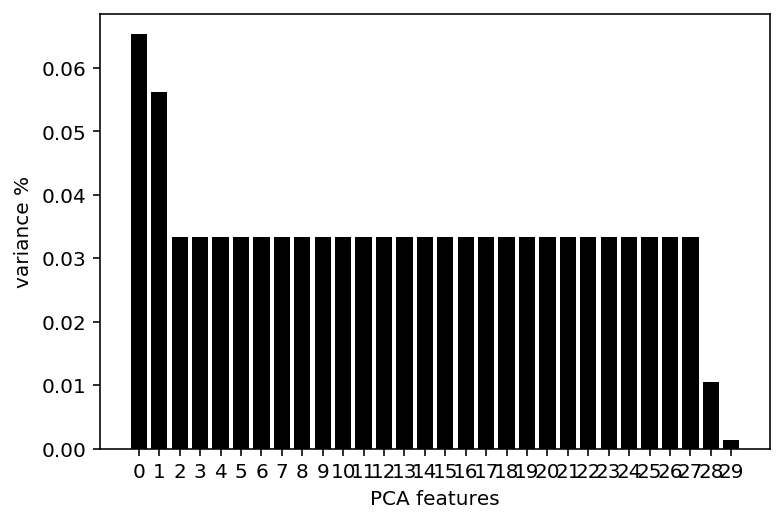

In [109]:
# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=len(df.columns))
principalComponents = pca.fit_transform(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

The first two componentes explains the majority of the variance in our data. We'll use them for visualizating the clusters

Text(0, 0.5, 'PCA 2')

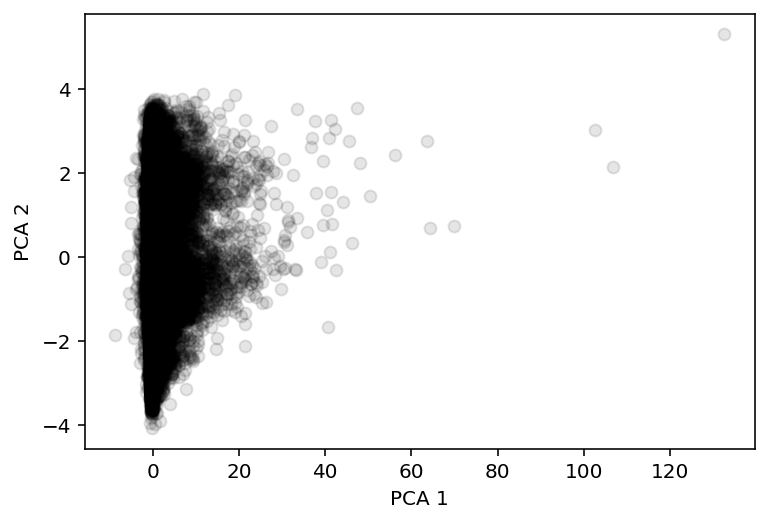

In [34]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Maybe it is no clearly distingable but it can be seen that a second cluster is taking form from 10 value in PCA 1 axis. Thanks to the labeled dataset, we know for sure there are two classes in our dataset.

### sklearn Clustering

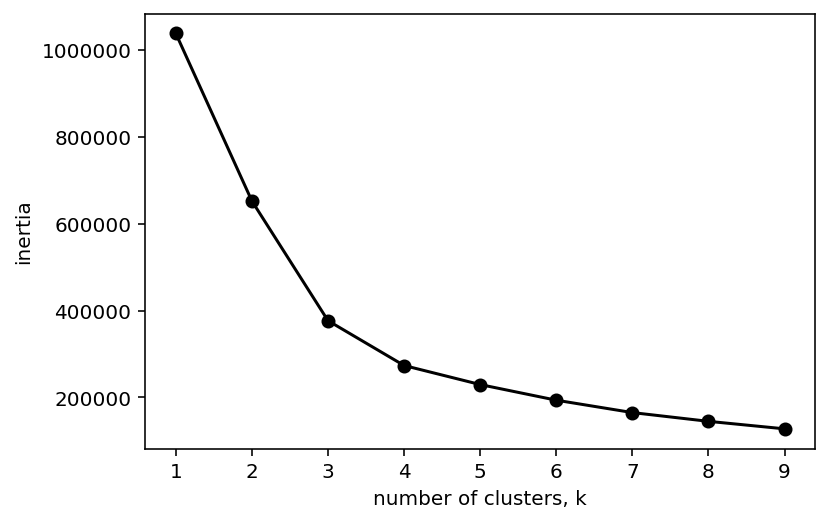

Exception ignored in: <function JavaWrapper.__del__ at 0x0000022E103074C8>
Traceback (most recent call last):
  File "C:\Users\Sampayo\anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'KMeans' object has no attribute '_java_obj'


In [112]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

After three clusters (the elbow point) we can say its mostly possible that the change in value of inertia and the variance of the data is no longer significant. 

We spected two clusters but maybe there is some data out of the "normal" card transaction activity but which is not credit fraud, so we can try with two and three clusters.

In [113]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(X)

In [129]:
unique, counts = np.unique(kmeans2.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[     0 129967]
 [     1 154840]]


In [130]:
unique, counts = np.unique(kmeans3.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[     0 128290]
 [     1 151812]
 [     2   4705]]


### Pyspark Clustering

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('cluster').getOrCreate()

data = spark.read.csv('E:\\Datasets\\creditcard.csv',inferSchema=True, header=True)

In [4]:
data.printSchema()

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

In [5]:
data.head(1)

[Row(Time=Decimal('0'), V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0)]

#### Scaling data: VectorAssembler

VectorAssembler is a transformer that combines a given list of columns into a single vector column. 

It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models

In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Time','V1','V2','V3','V4','V5',
                                        'V6','V7','V8','V9','V10','V11',
                                         'V12', 'V13','V14','V15', 'V16', 
                                       'V17', 'V18', 'V19', 'V20','V21', 
                                       'V22','V23', 'V24', 'V25', 'V26', 'V27',
                                         'V28','Amount'], 
                            outputCol='features')

final_data=assembler.transform(data)

final_data.printSchema()

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

#### Normalize data:StandScaler

StandardScaler transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean.

In [10]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler (inputCol='features', outputCol='scaledFeatures')

scaler_model = scaler.fit(final_data)

cluster_final_data  = scaler_model.transform(final_data)

In [91]:
df_pca = cluster_final_data

#### PCA in pyspark

In [98]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors  # Pre 2.0 pyspark.mllib.linalg

pca = PCAml(k=30, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_pca)

result = model.transform(df_pca).select("pcaFeatures")
result.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                                                                                                                                                                                                                                                                                                       

#### Kmeans

k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. 

In [78]:
from pyspark.ml.clustering import KMeans

#Training k-means model
kmeans2 = KMeans(featuresCol='scaledFeatures',k=2).setSeed(1)
kmeans3 = KMeans(featuresCol='scaledFeatures',k=3).setSeed(1)
model2 = kmeans2.fit(cluster_final_data)
model3 = kmeans3.fit(cluster_final_data)


#make predictions
predictions2 = model2.transform(cluster_final_data)
predictions3 = model3.transform(cluster_final_data)
model2.transform(cluster_final_data).groupBy('prediction').count().show()
model3.transform(cluster_final_data).groupBy('prediction').count().show()

#centroids
#centers = model.clusterCenters()

+----------+------+
|prediction| count|
+----------+------+
|         1| 41621|
|         0|243186|
+----------+------+

+----------+------+
|prediction| count|
+----------+------+
|         1| 44649|
|         2|110623|
|         0|129535|
+----------+------+



In [80]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions2)
print('********** Two clusters **********')
print("Silhouette with squared euclidean distance = " + str(silhouette))
silhouette = evaluator.evaluate(predictions3)
print('********** Three clusters **********')
print("Silhouette with squared euclidean distance = " + str(silhouette))

********** Two clusters **********
Silhouette with squared euclidean distance = -0.026089400308975563
********** Three clusters **********
Silhouette with squared euclidean distance = 0.4311889274113219


The two clusters model have a poor accuracy. So it's clear there is a third type of credit card transactions which are nor "usual" or fraud.

Cluster Centers: 
[ 1.99058198e+00 -9.50337306e-03  1.49788558e-01  1.27045977e-02
  1.21083604e-01  1.19215208e-01 -2.46630518e-02  3.73924722e-02
  1.07801040e-02  1.58367080e-01 -1.10950830e-01  3.06414489e-02
  4.01851404e-02 -4.04036595e-02  1.65903592e-02  1.77272612e-02
  1.73843121e-01 -2.95029604e-02 -1.51639863e-01  8.72675408e-02
  1.65177834e-02  2.75135386e-02  6.12677360e-02  3.41111980e-03
  2.87086347e-03  1.22136634e-02  6.07828480e-04 -2.83168656e-03
 -1.97129885e-03  2.40477792e-01]
[ 2.03162233  0.05552695 -0.87519474 -0.07423128 -0.70747549 -0.6965587
  0.14410295 -0.21847927 -0.06298672 -0.92531791  0.64827103 -0.17903393
 -0.23479646  0.23607324 -0.09693528 -0.10357804 -1.01574237  0.1723819
  0.88601167 -0.5098927  -0.09651122 -0.16075797 -0.35797928 -0.01993072
 -0.01677408 -0.07136282 -0.00355146  0.01654517  0.01151804  1.01201785]
